<a href="https://colab.research.google.com/github/skreddypalvai/2EMtf9Oi5Ts8qRbT/blob/main/1Value_Investor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Value Investing**

## Objective:
The main goal is to predict 2021 stock prices of given portfolio companies using trading data from emerging markets, including 2020 stock price data. Additionally, we aim to recommend Buy, Hold, Sell decisions, with a focus on maximizing capital returns and minimizing losses. Our evaluation will be based on capital returns, and we will also utilize Bollinger Bands to gauge our system's effectiveness.

### Importing libraries and loading the data

In [ ]:
#necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
#loading 8 companies stock data sheets
filepath = '/content/drive/MyDrive/Colab Notebooks/2020Q1Q2Q3Q4-2021Q1.xlsx'
sheet_names = ['Russia - Sberbank Rossii PAO (S', 'Turkey - Koc Holding AS (KCHOL)', 'Egypt - Medinet Nasr Housing (M',
               'Brazil - Minerva SABrazil (BEEF', 'Argentina - Pampa Energia SA (P', 'Colombia - Cementos Argos SA (C',
               'South Africa - Impala Platinum ','South Korea - Dongkuk Steel Mil']
# Create an empty dictionary to store the sheets
sheets = {}
for sheet_name in sheet_names:
    df = pd.read_excel(filepath, sheet_name=sheet_name, index_col='Date', parse_dates=['Date'])
    sheets[sheet_name] = df

In [ ]:
# Accessing the individual company stocks info from the dictionary
russia_df = sheets['Russia - Sberbank Rossii PAO (S']
turkey_df = sheets['Turkey - Koc Holding AS (KCHOL)']
egypt_df = sheets['Egypt - Medinet Nasr Housing (M']
brazil_df = sheets['Brazil - Minerva SABrazil (BEEF']
argentina_df = sheets['Argentina - Pampa Energia SA (P']
colombia_df = sheets['Colombia - Cementos Argos SA (C']
southafrica_df = sheets['South Africa - Impala Platinum ']
south_korea_df = sheets['South Korea - Dongkuk Steel Mil']

## **EDA**

In [ ]:
# We will visualize the stock price movement by using High-Low range values and by highlighting the Price column values.

for sheet_name, df in sheets.items():
    print('_'*160)
    plt.figure(figsize=(12, 6))
    plt.fill_between(df.index, df['High'], df['Low'], color='skyblue', alpha=0.4, label='High-Low Range')
    plt.plot(df.index, df['Price'], color='red', label='Price')
    plt.title(f'Stock Price Movement: {sheet_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
for sheet_name, df in sheets.items():
  print('_'*170)
  plt.figure(figsize=(13,7))
  plt.plot(df.index, df['High'], label='High')
  plt.plot(df.index, df['Low'], label='Low')
  plt.plot(df.index, df['Open'], label='Open')
  plt.title(f'Stock Price Movement: {sheet_name}')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
#we will use candlestick charts to accurately track stock price movements
for sheet_name, df in sheets.items():
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Price'])])
    fig.update_layout(
        title=f'Stock Price Movement: {sheet_name}',
        xaxis_title='Date',
        yaxis_title='Price',
        template='presentation',
        shapes=[dict(
                x0=df.index[0], x1=df.index[-1], y0=0, y1=1, xref='x', yref='paper',
                line_width=0, fillcolor='rgba(0,0,0,0)', opacity=0.2
            )],
        annotations=[dict(
                x=df.index[0], y=0.05, xref='x', yref='paper',
                showarrow=False, xanchor='left',
                text=f'Date: {df.index[0]}', font=dict(size=10)
            )]
    )
    fig.show()

## Data Preprocessing

In [ ]:
# Clear the current session
K.clear_session()

In [ ]:
# Replacing the Million-'M', Thousand -'k', and '-' terms in Volume feature
#  and splitting the dataset into 2020 data for training and 2021 data for testing.
def preprocess(data):
    data['Vol.'] = data['Vol.'].str.replace('-', '0').str.replace('M', '').str.replace('K', 'e3').astype(float)
    data['Vol.'] *= 1e6
    data['Change %'] = data['Change %'].abs()
    test = data['2021']
    train = data.loc[:'2020-12-31']
    return test, train

In [ ]:
#scaling
scaler = MinMaxScaler()

In [ ]:
#preparing time sequence data
def prepare_data_for_lstm(data, column, time_steps):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, column])
    return np.array(X), np.array(y)

In [ ]:
# we will be using Univariate LSTM
def prepare_and_reshape(data, target_column, scaler, time_steps):
    price_data = data[[target_column]].values.reshape(-1, 1)
    price_data_scaled = scaler.fit_transform(price_data)
    X, y = prepare_data_for_lstm(price_data_scaled,column=0 , time_steps=time_steps)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

### Model building and evaluation

In [ ]:
# considering the less training data, we will build a simple LSTM model architecture
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# preprocessing the test data to evaluate the model
def preprocess_test_data(data, scaler, target_column, time_steps, model):
    test_data = data[[target_column]].values.reshape(-1, 1)
    test_data_scaled = scaler.transform(test_data)
    X_test, y_test = prepare_data_for_lstm(test_data_scaled,column =0, time_steps=time_steps)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # Predicting using the model
    predictions = model.predict(X_test)
    # Inverse transform the actual values to the original scale
    y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))
    predictions_original_scale = scaler.inverse_transform(predictions)
    return y_test_original_scale, predictions_original_scale

In [ ]:
#visualizing predictions
def evaluate_and_visualize(y_true, y_pred):
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    # Visualize predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Stock Prices')
    plt.title('2021 Actual and Predicted stock prices')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.9)
    plt.show()

In [ ]:
# Define a function to calculate Bollinger Bands
def calculate_bollinger_bands(predictions_, window, num_std):
    rolling_mean = predictions_.rolling(window=window).mean()
    rolling_std = predictions_.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return rolling_mean, upper_band, lower_band

In [ ]:
# Designing a trading strategy to determine optimal Buy and Sell points using the upper
#and lower bands calculated from Bollinger Bands, and also integrating a trailing stop to maximize profits.

def stock_analysis(y_predicted,rolling_mean, upper_band, lower_band, trailing_stop, initial_capital,y_actual,company):
    capital = initial_capital
    shares_held = 0
    current_price = None
    sells = []
    buys = []
    highest_price = 0
    for i in range(len(y_predicted)):
        if current_price is not None:
            if y_predicted[i] > upper_band[i] and shares_held > 0:
                capital += shares_held * current_price
                shares_held = 0
                sells.append((i, current_price))
                print(f"Sell at {current_price}")
            elif y_predicted[i] < lower_band[i] and capital > 0:
                shares_held = capital / y_predicted[i]
                capital = 0
                buys.append((i, y_predicted[i]))
                print(f"Buy at {y_predicted[i]}")
                highest_price = y_predicted[i]
            elif shares_held > 0 and y_predicted[i] > highest_price:
                highest_price = y_predicted[i]
            elif shares_held > 0 and y_predicted[i] < (1 - trailing_stop) * highest_price:
                capital += shares_held * y_predicted[i]
                shares_held = 0
                sells.append((i, y_predicted[i]))
                print(f"Sell at {y_predicted[i]}")
        current_price = y_predicted[i]
    if shares_held > 0:
        capital += shares_held * current_price
    print(f"Initial Capital: {initial_capital}")
    print(f"Final Capital: {capital}")
    plt.figure(figsize=(10, 6))
    plt.plot(y_actual, label='Actual Price',linewidth=1)
    plt.plot(y_predicted, label='Predicted Price', linewidth=1.5)
    plt.plot(rolling_mean, label='Middle Band',linewidth=1)
    plt.plot(upper_band, label='Upper Band',linewidth=1.5,linestyle='--')
    plt.plot(lower_band, label='Lower Band',linewidth=1.5,linestyle='--')
# Plot the actions
    buy_points, buy_values = zip(*buys)
    sell_points, sell_values = zip(*sells)
    plt.scatter(buy_points, buy_values, color='green', marker='^', label='Buy Signal')
    plt.scatter(sell_points, sell_values, color='red', marker='v', label='Sell Signal')
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.title(f'2021 Stock Price \n {company}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

## **RUSSIA**
##  Sberbank Rossii PAO (SBER)

In [ ]:
russia_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00M,-0.0076
2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.0002
2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56.07M,0.0159
2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.0030


In [ ]:
russia_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.0+ KB


In [ ]:
russia_test,russia_train = preprocess(russia_df)

<ipython-input-5-70c65ac5f485>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = data['2021']


In [ ]:
russia_train.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-30,271.65,272.49,274.24,270.12,31530000.0,0.0013
2020-12-29,272.00,275.91,276.43,271.26,39020000.0,0.0098
2020-12-28,274.70,270.90,275.19,269.73,39040000.0,0.0150
2020-12-25,270.64,269.97,271.00,268.28,11990000.0,0.0049
2020-12-24,269.32,271.98,272.82,267.13,42610000.0,0.0029


In [ ]:
russia_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2020-12-30 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     250 non-null    float64
 1   Open      250 non-null    float64
 2   High      250 non-null    float64
 3   Low       250 non-null    float64
 4   Vol.      250 non-null    float64
 5   Change %  250 non-null    float64
dtypes: float64(6)
memory usage: 13.7 KB


In [ ]:
russia_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2021-03-31 to 2021-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     61 non-null     float64
 1   Open      61 non-null     float64
 2   High      61 non-null     float64
 3   Low       61 non-null     float64
 4   Vol.      61 non-null     float64
 5   Change %  61 non-null     float64
dtypes: float64(6)
memory usage: 3.3 KB


In [ ]:
X_train1,y_train1 = prepare_and_reshape(russia_train,target_column='Price',scaler=scaler,time_steps = 15)

In [ ]:
input_shape1 = (X_train1.shape[1], X_train1.shape[2])  # (time_steps, features)
model1 = build_lstm_model(input_shape1)

In [ ]:
model1.fit(X_train1, y_train1, epochs=50, batch_size=16)

Epoch 1/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 2/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0041
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 4/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 7/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 8/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 9/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0040
Epoch 10/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 11/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 12/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 13/50
15/15 [==============================

In [ ]:
y_test_original_scale1, predictions_original_scale1 = preprocess_test_data(
    russia_test, scaler=scaler, target_column='Price', time_steps=15, model=model1)

2/2 [==============================] - 0s 6ms/step


Mean Absolute Error (MAE): 5.81
Root Mean Squared Error (RMSE): 7.03


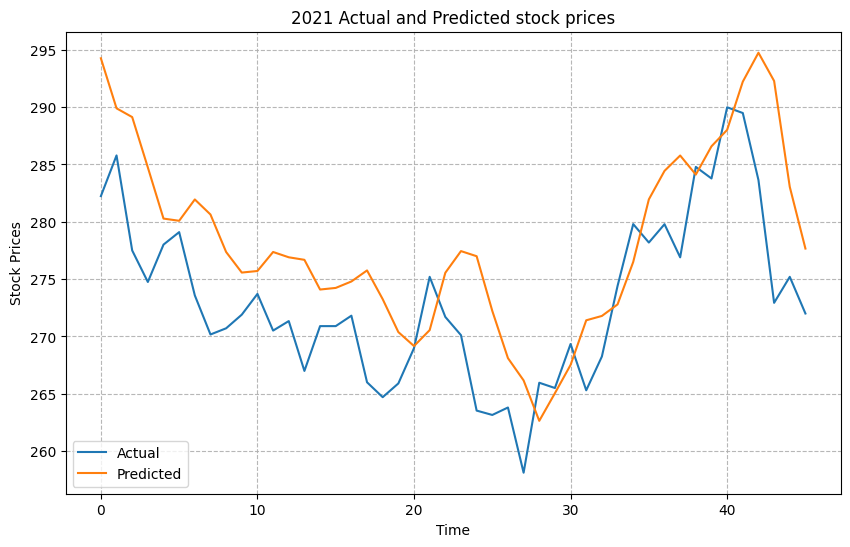

In [ ]:
evaluate_and_visualize(y_test_original_scale1,predictions_original_scale1)

In [ ]:
y_predicted1= np.squeeze(predictions_original_scale1)
y_actual_russia1 = np.squeeze(y_test_original_scale1)
y_predicted1 = pd.Series(y_predicted1)

In [ ]:
rolling_mean1, upper_band1, lower_band1 = calculate_bollinger_bands(y_predicted1,window=14, num_std=2)

Buy at 269.160888671875
Sell at 268.1051330566406
Buy at 262.63677978515625
Sell at 283.0483703613281
Initial Capital: 10000
Final Capital: 10734.907074818495


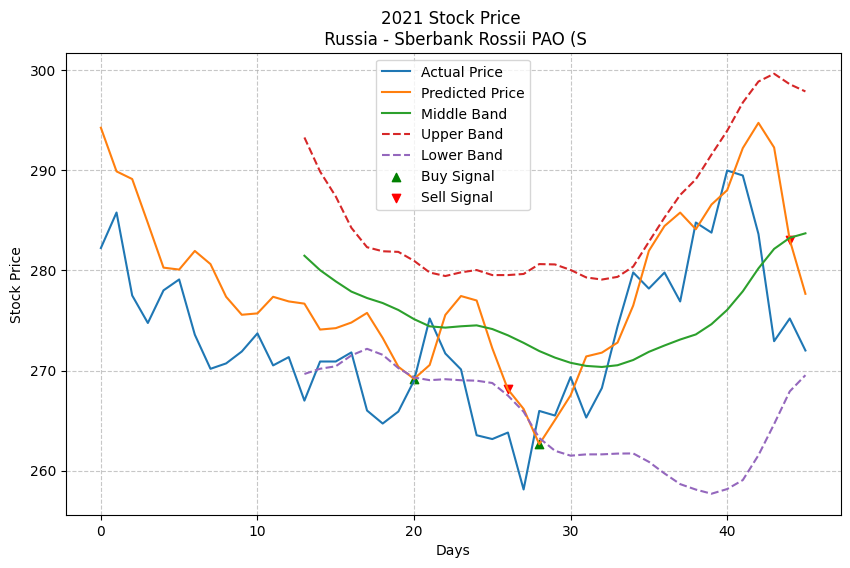

In [ ]:
stock_analysis(y_predicted1,rolling_mean1, upper_band1, lower_band1, trailing_stop=0.02, initial_capital=10000,y_actual=y_actual_russia1,company= 'Russia - Sberbank Rossii PAO (S')

By fine-tuning the window size, trailing stop, and standard deviation values, we obtained a 7.4% return on capital with maximum profit for predicted SBER stocks, while also considering the recommended Buy and Sell signals.

## **TURKEY**
##  Koc Holding AS (KCHOL.IS)

In [ ]:
turkey_df.head(6)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,19.41,19.42,19.63,19.27,13.14M,-0.0046
2021-03-30,19.50,19.12,19.81,19.03,21.05M,0.0209
2021-03-29,19.10,19.24,19.67,19.10,16.56M,-0.0078
2021-03-26,19.25,20.28,20.36,19.10,21.35M,-0.0385
2021-03-25,20.02,20.50,20.86,20.02,15.93M,-0.0148
2021-03-24,20.32,20.54,21.00,20.16,20.42M,-0.0020


In [ ]:
turkey_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2021-03-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     315 non-null    float64
 1   Open      315 non-null    float64
 2   High      315 non-null    float64
 3   Low       315 non-null    float64
 4   Vol.      315 non-null    object 
 5   Change %  315 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.2+ KB


In [ ]:
turkey_test,turkey_train = preprocess(turkey_df)

<ipython-input-5-70c65ac5f485>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = data['2021']


In [ ]:
turkey_train.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-31,21.12,20.84,21.38,20.72,7120000.0,0.0086
2020-12-30,20.94,20.72,21.08,20.62,10050000.0,0.0155
2020-12-29,20.62,20.04,20.66,20.00,9930000.0,0.0310
2020-12-28,20.00,19.92,20.12,19.92,4680000.0,0.0050
2020-12-25,19.90,19.94,20.08,19.83,2940000.0,0.0035


In [ ]:
turkey_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-12-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     252 non-null    float64
 1   Open      252 non-null    float64
 2   High      252 non-null    float64
 3   Low       252 non-null    float64
 4   Vol.      252 non-null    float64
 5   Change %  252 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


In [ ]:
turkey_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 2021-03-31 to 2021-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     63 non-null     float64
 1   Open      63 non-null     float64
 2   High      63 non-null     float64
 3   Low       63 non-null     float64
 4   Vol.      63 non-null     float64
 5   Change %  63 non-null     float64
dtypes: float64(6)
memory usage: 3.4 KB


In [ ]:
X_train2, y_train2 = prepare_and_reshape(turkey_train,target_column='Price',scaler=scaler,time_steps = 5)

In [ ]:
X_train2.shape

(247, 5, 1)

In [ ]:
input_shape2 = (X_train2.shape[1], X_train2.shape[2])
model2 = build_lstm_model(input_shape2)

In [ ]:
model2.fit(X_train2, y_train2, epochs=50, batch_size=16)

Epoch 1/50
16/16 [==============================] - 3s 6ms/step - loss: 0.2228
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1247
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0423
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0132
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0074
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 8/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0057
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 11/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 12/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 13/50
16/16 [========================

In [ ]:
y_test_turkey_scale, predictions_turkey_scale = preprocess_test_data(
    turkey_test, scaler=scaler, target_column='Price', time_steps=5, model=model2)

2/2 [==============================] - 0s 6ms/step


Mean Absolute Error (MAE): 0.50
Root Mean Squared Error (RMSE): 0.68


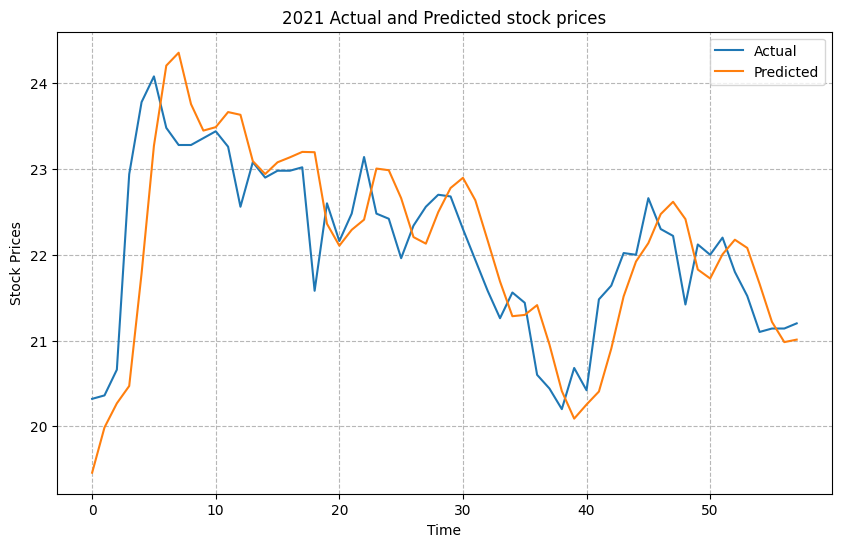

In [ ]:
#Turkey
evaluate_and_visualize(y_test_turkey_scale,predictions_turkey_scale)

In [ ]:
predictions_turkey_scale.shape

(58, 1)

In [ ]:
y_predicted2 = np.squeeze(predictions_turkey_scale)
y_actual_turkey = np.squeeze(y_test_turkey_scale)
y_predicted2 = pd.Series(y_predicted2)

In [ ]:
rolling_mean2, upper_band2, lower_band2 = calculate_bollinger_bands(y_predicted2,window=16, num_std=1.5)

Buy at 22.10567283630371
Sell at 22.206119537353516
Buy at 21.688133239746094
Sell at 20.952739715576172
Buy at 20.410661697387695
Sell at 22.474266052246094
Initial Capital: 10000
Final Capital: 10686.020767637361


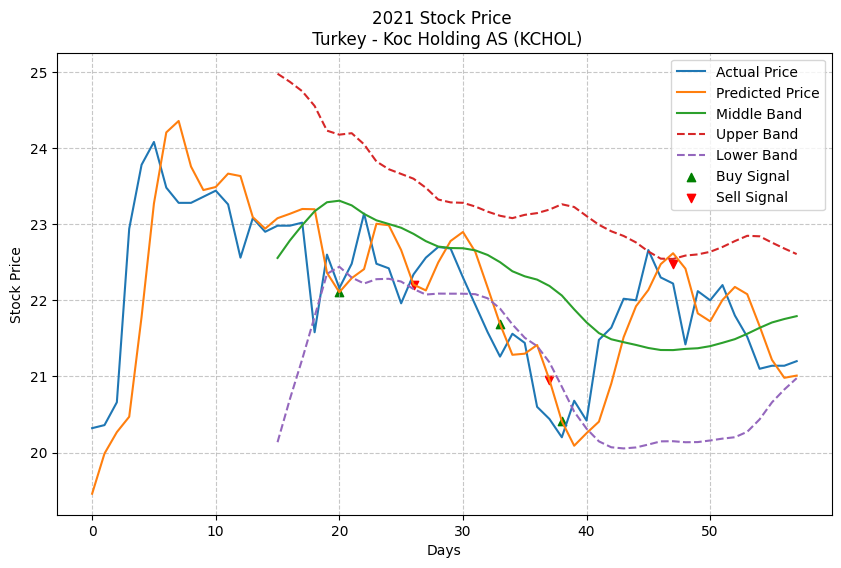

In [ ]:
stock_analysis(y_predicted2,rolling_mean2, upper_band2, lower_band2, trailing_stop=0.02, initial_capital=10000,y_actual=y_actual_turkey,company= 'Turkey - Koc Holding AS (KCHOL)')

It is evident that our system recommended the best Buy and Sell signals, meticulously analyzing market trends and key indicators, to guide users towards achieving maximum profit, all while ensuring decent capital returns and minimizing potential risks.

##  **EGYPT**
##  Madinet Nasr for Housing and Development SAE(MASR)

In [ ]:
egypt_df.head(6)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,3.75,3.74,3.82,3.71,1.57M,0.0054
2021-03-30,3.73,3.71,3.76,3.67,3.43M,0.0081
2021-03-29,3.70,3.69,3.73,3.68,1.25M,-0.0027
2021-03-28,3.71,3.76,3.76,3.68,2.34M,0.0000
2021-03-25,3.71,3.62,3.78,3.59,2.50M,0.0137
2021-03-24,3.66,3.69,3.74,3.60,1.75M,0.0195


In [ ]:
egypt_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2021-03-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     305 non-null    float64
 1   Open      305 non-null    float64
 2   High      305 non-null    float64
 3   Low       305 non-null    float64
 4   Vol.      305 non-null    object 
 5   Change %  305 non-null    float64
dtypes: float64(5), object(1)
memory usage: 16.7+ KB


In [ ]:
egypt_test,egypt_train = preprocess(egypt_df)

<ipython-input-5-70c65ac5f485>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = data['2021']


In [ ]:
egypt_train.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-31,3.82,3.82,3.85,3.77,1650000.0,0.0000
2020-12-30,3.82,3.79,3.86,3.76,3760000.0,0.0160
2020-12-29,3.76,3.74,3.79,3.70,1740000.0,0.0108
2020-12-28,3.72,3.65,3.76,3.65,1930000.0,0.0192
2020-12-27,3.65,3.70,3.70,3.60,1120000.0,0.0027


In [ ]:
egypt_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2020-12-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     243 non-null    float64
 1   Open      243 non-null    float64
 2   High      243 non-null    float64
 3   Low       243 non-null    float64
 4   Vol.      243 non-null    float64
 5   Change %  243 non-null    float64
dtypes: float64(6)
memory usage: 13.3 KB


In [ ]:
egypt_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2021-03-31 to 2021-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     62 non-null     float64
 1   Open      62 non-null     float64
 2   High      62 non-null     float64
 3   Low       62 non-null     float64
 4   Vol.      62 non-null     float64
 5   Change %  62 non-null     float64
dtypes: float64(6)
memory usage: 3.4 KB


In [ ]:
X_train_egypt, y_train_egypt = prepare_and_reshape(egypt_train,target_column='Price',scaler=scaler,time_steps= 5)

In [ ]:
X_train_egypt.shape

(238, 5, 1)

In [ ]:
input_shape3 = (X_train_egypt.shape[1], X_train_egypt.shape[2])
model3 = build_lstm_model(input_shape3)
model3.fit(X_train_egypt, y_train_egypt, epochs=50, batch_size=16)

Epoch 1/50
15/15 [==============================] - 2s 4ms/step - loss: 0.1901
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.1020
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0358
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0160
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 9/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 11/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 12/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 13/50
15/15 [==============================

In [ ]:
y_test_egypt_scale, predictions_egypt_scale = preprocess_test_data(
    egypt_test, scaler=scaler, target_column='Price', time_steps=5, model=model3)

2/2 [==============================] - 0s 6ms/step


Mean Absolute Error (MAE): 0.07
Root Mean Squared Error (RMSE): 0.09


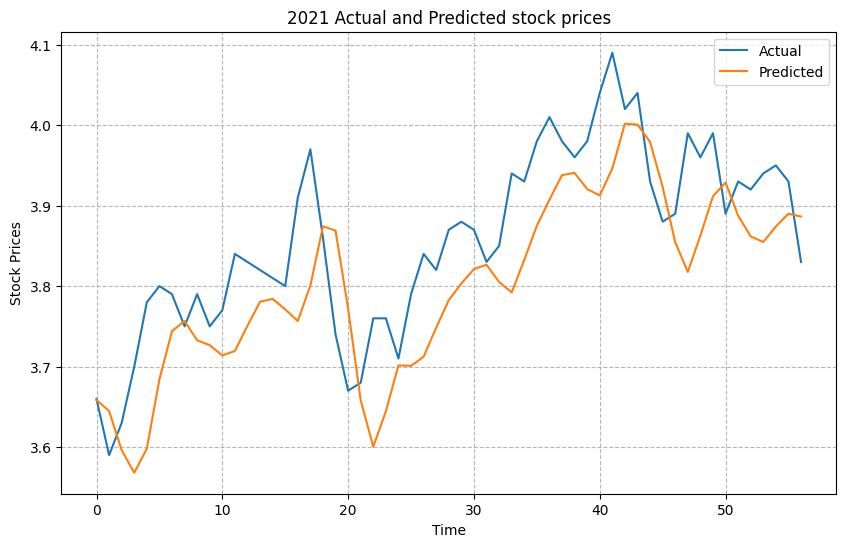

In [ ]:
evaluate_and_visualize(y_test_egypt_scale,predictions_egypt_scale)

In [ ]:
y_pred_egypt = np.squeeze(predictions_egypt_scale)
y_actual_egypt = np.squeeze(y_test_egypt_scale)
y_pred_egypt= pd.Series(y_pred_egypt)

In [ ]:
rolling_mean3, upper_band3, lower_band3 = calculate_bollinger_bands(y_pred_egypt,window=14, num_std=2)

Buy at 3.600351572036743
Sell at 3.923095941543579
Initial Capital: 1000
Final Capital: 1089.6424593680047


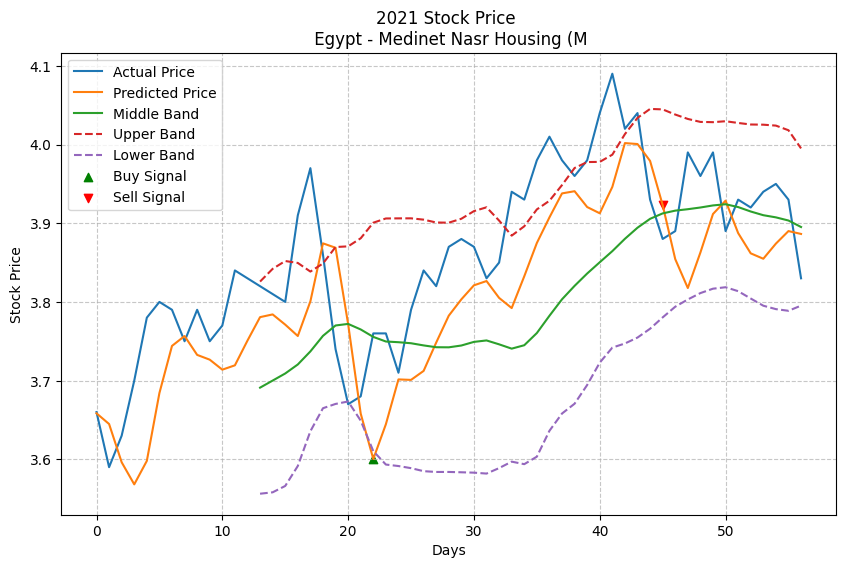

In [ ]:
stock_analysis(y_pred_egypt,rolling_mean3, upper_band3, lower_band3, trailing_stop=0.01, initial_capital=1000,y_actual=y_actual_egypt,company= 'Egypt - Medinet Nasr Housing (M')

Achieving an impressive 9% of capital returns with the best trading strategy.

## **BRAZIL**
##  Minerva SABrazil(BEEF3)

In [ ]:
brazil_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2021-03-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     309 non-null    float64
 1   Open      309 non-null    float64
 2   High      309 non-null    float64
 3   Low       309 non-null    float64
 4   Vol.      309 non-null    object 
 5   Change %  309 non-null    float64
dtypes: float64(5), object(1)
memory usage: 16.9+ KB


In [ ]:
brazil_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,10.20,10.35,10.40,10.12,7.77M,-0.0154
2021-03-30,10.36,10.41,10.62,10.30,9.93M,-0.0105
2021-03-29,10.47,9.85,10.50,9.81,22.04M,0.0651
2021-03-26,9.83,9.80,9.94,9.70,5.11M,0.0031
2021-03-25,9.80,10.01,10.01,9.66,8.88M,-0.0151


In [ ]:
brazil_test,brazil_train = preprocess(brazil_df)

<ipython-input-5-70c65ac5f485>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = data['2021']


In [ ]:
brazil_train.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-30,10.18,10.42,10.47,10.15,8040000.0,0.0174
2020-12-29,10.36,10.35,10.53,10.29,7630000.0,0.0068
2020-12-28,10.29,10.41,10.42,10.21,7550000.0,0.0077
2020-12-23,10.37,10.70,10.79,10.34,11360000.0,0.0254
2020-12-22,10.64,10.32,10.78,10.30,20400000.0,0.0411


In [ ]:
brazil_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2020-12-30 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     249 non-null    float64
 1   Open      249 non-null    float64
 2   High      249 non-null    float64
 3   Low       249 non-null    float64
 4   Vol.      249 non-null    float64
 5   Change %  249 non-null    float64
dtypes: float64(6)
memory usage: 13.6 KB


In [ ]:
brazil_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2021-03-31 to 2021-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     60 non-null     float64
 1   Open      60 non-null     float64
 2   High      60 non-null     float64
 3   Low       60 non-null     float64
 4   Vol.      60 non-null     float64
 5   Change %  60 non-null     float64
dtypes: float64(6)
memory usage: 3.3 KB


In [ ]:
X_train4,y_train4 = prepare_and_reshape(brazil_train,target_column='Price',scaler=scaler,time_steps=7)

In [ ]:
input_shape4 = (X_train4.shape[1], X_train4.shape[2])
model4 = build_lstm_model(input_shape4)

In [ ]:
model4.fit(X_train4, y_train4, epochs=50, batch_size=16)

Epoch 1/50
16/16 [==============================] - 1s 3ms/step - loss: 0.2531
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 13/50
16/16 [==============================

In [ ]:
y_test_brazil_scale, predictions_brazil_scale = preprocess_test_data(
    brazil_test, scaler=scaler, target_column='Price', time_steps=7, model=model4)

2/2 [==============================] - 0s 7ms/step


Mean Absolute Error (MAE): 0.19
Root Mean Squared Error (RMSE): 0.23


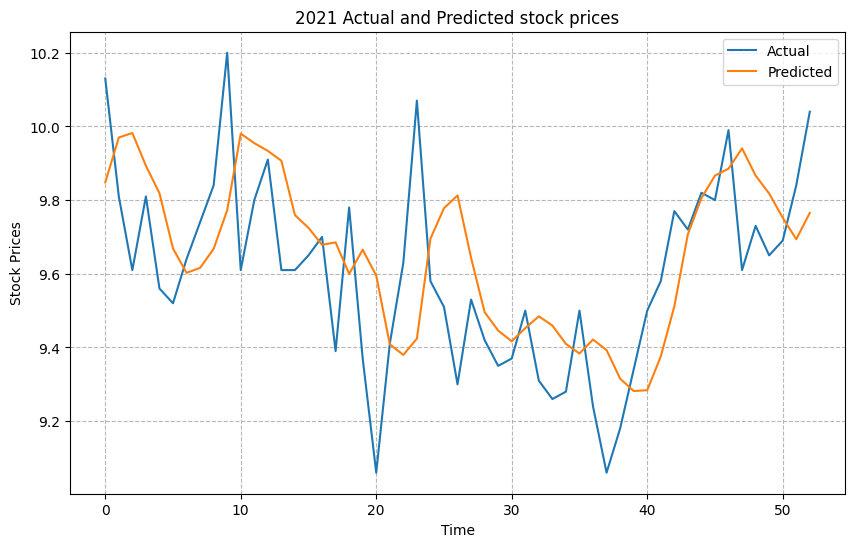

In [ ]:
evaluate_and_visualize(y_test_brazil_scale,predictions_brazil_scale)

In [ ]:
y_predicted4= np.squeeze(predictions_brazil_scale)
y_actual_brazil = np.squeeze(y_test_brazil_scale)
y_predicted4 = pd.Series(y_predicted4)

In [ ]:
rolling_mean4, upper_band4, lower_band4 = calculate_bollinger_bands(y_predicted4,window=6, num_std=1.5)

Buy at 9.668728828430176
Sell at 9.772615432739258
Buy at 9.40858268737793
Sell at 9.643331527709961
Buy at 9.315329551696777
Sell at 9.375589370727539
Buy at 9.752184867858887
Initial Capital: 1000
Final Capital: 1044.0604823992242


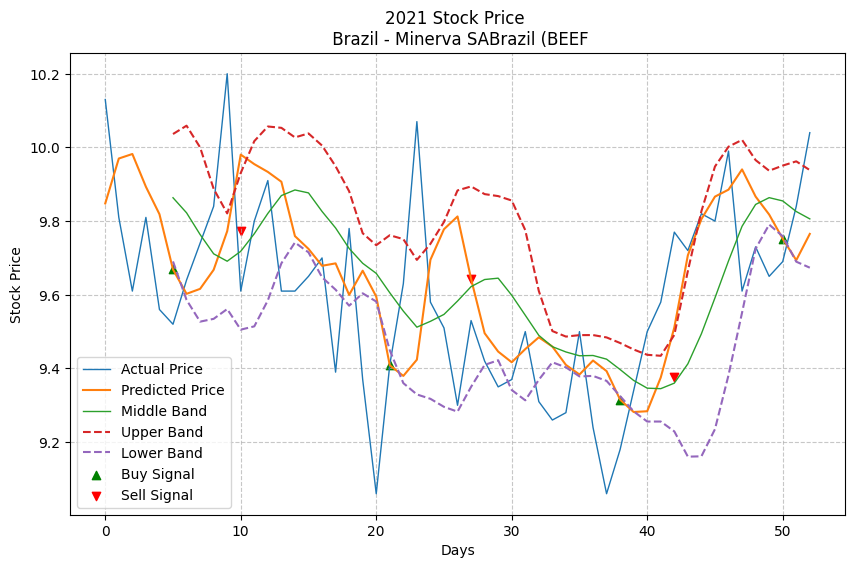

In [ ]:
stock_analysis(y_predicted4,rolling_mean4, upper_band4, lower_band4, trailing_stop=0.01, initial_capital=1000,y_actual=y_actual_brazil,company= 'Brazil - Minerva SABrazil (BEEF')

Our system provided optimal Buy and Sell signals, ensuring good returns while minimizing risks and losses.

## **ARGENTINA**
##  Pampa Energia SA(PAM)

In [ ]:
argentina_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2021-03-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     300 non-null    float64
 1   Open      300 non-null    float64
 2   High      300 non-null    float64
 3   Low       300 non-null    float64
 4   Vol.      300 non-null    object 
 5   Change %  300 non-null    float64
dtypes: float64(5), object(1)
memory usage: 16.4+ KB


In [ ]:
argentina_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,85.15,86.50,88.10,85.15,564.30K,-0.0110
2021-03-30,86.10,85.15,86.75,84.60,141.40K,0.0129
2021-03-29,85.00,80.00,86.00,79.00,371.22K,0.0385
2021-03-26,81.85,84.00,84.60,80.70,462.55K,-0.0209
2021-03-25,83.60,85.20,87.30,82.10,389.78K,-0.0313


In [ ]:
argentina_test,argentina_train = preprocess(argentina_df)

<ipython-input-5-70c65ac5f485>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = data['2021']


In [ ]:
argentina_train.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-30,76.90,76.6,78.90,75.90,8.380500e+11,0.0039
2020-12-29,76.60,74.5,78.25,73.60,4.995700e+11,0.0351
2020-12-28,74.00,77.0,77.30,74.00,8.550300e+11,0.0427
2020-12-23,77.30,76.5,78.00,75.05,9.300500e+11,0.0300
2020-12-22,75.05,78.5,79.45,75.00,8.557500e+11,0.0253


In [ ]:
argentina_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2020-12-30 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     240 non-null    float64
 1   Open      240 non-null    float64
 2   High      240 non-null    float64
 3   Low       240 non-null    float64
 4   Vol.      240 non-null    float64
 5   Change %  240 non-null    float64
dtypes: float64(6)
memory usage: 13.1 KB


In [ ]:
argentina_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2021-03-31 to 2021-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     60 non-null     float64
 1   Open      60 non-null     float64
 2   High      60 non-null     float64
 3   Low       60 non-null     float64
 4   Vol.      60 non-null     float64
 5   Change %  60 non-null     float64
dtypes: float64(6)
memory usage: 3.3 KB


In [ ]:
X_train5,y_train5 = prepare_and_reshape(argentina_train,target_column='Price',scaler=scaler,time_steps=7)

In [ ]:
input_shape5 = (X_train5.shape[1], X_train5.shape[2])
model5 = build_lstm_model(input_shape5)

In [ ]:
model5.fit(X_train5, y_train5, epochs=50, batch_size=16)

Epoch 1/50
15/15 [==============================] - 1s 3ms/step - loss: 0.1946
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 11/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 12/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 13/50
15/15 [==============================

In [ ]:
y_test_argentina_scale, predictions_argentina_scale = preprocess_test_data(
    argentina_test, scaler=scaler, target_column='Price', time_steps=7, model=model5)

2/2 [==============================] - 0s 7ms/step


Mean Absolute Error (MAE): 1.82
Root Mean Squared Error (RMSE): 2.38


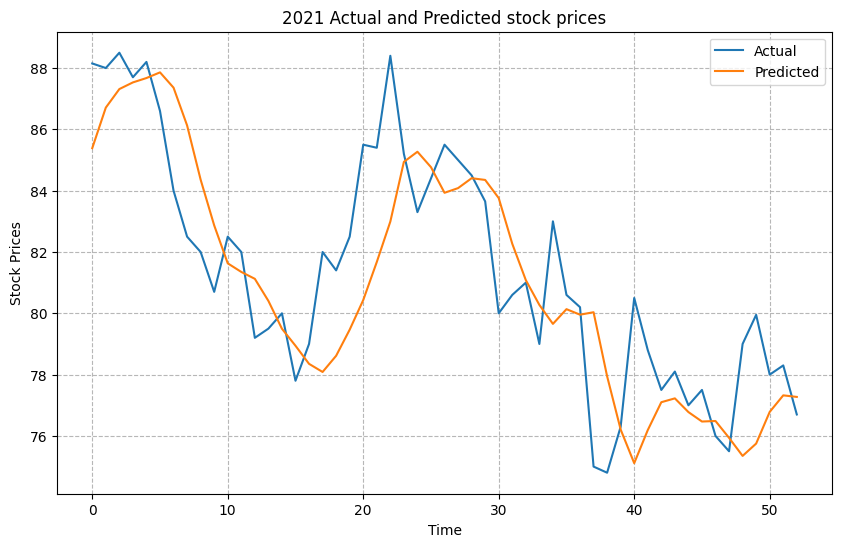

In [ ]:
evaluate_and_visualize(y_test_argentina_scale,predictions_argentina_scale)

In [ ]:
y_predicted5= np.squeeze(predictions_argentina_scale)
y_actual_argentina = np.squeeze(y_test_argentina_scale)
y_predicted5 = pd.Series(y_predicted5)

In [ ]:
rolling_mean5, upper_band5, lower_band5 = calculate_bollinger_bands(y_predicted5,window=17, num_std=1.5)

Buy at 78.35154724121094
Sell at 82.99220275878906
Buy at 77.9460220336914
Sell at 76.20901489257812
Buy at 75.11115264892578
Sell at 75.93772888183594
Initial Capital: 1000
Final Capital: 1047.0207389174852


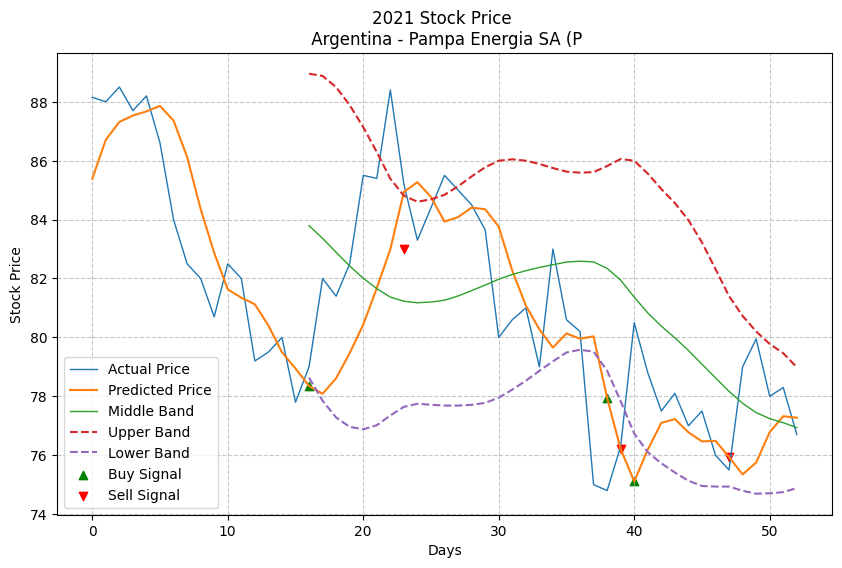

In [ ]:
stock_analysis(y_predicted5,rolling_mean5, upper_band5, lower_band5, trailing_stop=0.01, initial_capital=1000,y_actual=y_actual_argentina,company= 'Argentina - Pampa Energia SA (P')

Pampa Energia achieved favorable capital returns through strategic timing in their buying and selling endeavors.

## **COLOMBIA**
##  Cementos Argos S.A.(CEMARGOS)

In [ ]:
colombia_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,5150,5100,5170,5100,212.44K,0.0098
2021-03-30,5100,5010,5100,5010,583.70K,0.0109
2021-03-29,5045,5020,5045,5015,117.54K,0.0050
2021-03-26,5020,5085,5085,4980,203.46K,-0.0020
2021-03-25,5030,5035,5045,4950,317.06K,0.0010


In [ ]:
colombia_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303 entries, 2021-03-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     303 non-null    int64  
 1   Open      303 non-null    int64  
 2   High      303 non-null    int64  
 3   Low       303 non-null    int64  
 4   Vol.      303 non-null    object 
 5   Change %  303 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 16.6+ KB


In [ ]:
colombia_test,colombia_train = preprocess(colombia_df)

<ipython-input-5-70c65ac5f485>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = data['2021']


In [ ]:
colombia_train.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-30,6180,6180,6275,6020,6.517900e+11,0.0000
2020-12-29,6180,5900,6180,5900,8.767200e+11,0.0492
2020-12-28,5890,5705,5890,5705,3.398700e+11,0.0333
2020-12-24,5700,5780,5780,5700,1.042000e+10,0.0087
2020-12-23,5750,5870,5890,5720,5.272800e+11,0.0120


In [ ]:
colombia_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2020-12-30 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     242 non-null    int64  
 1   Open      242 non-null    int64  
 2   High      242 non-null    int64  
 3   Low       242 non-null    int64  
 4   Vol.      242 non-null    float64
 5   Change %  242 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 13.2 KB


In [ ]:
colombia_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2021-03-31 to 2021-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     61 non-null     int64  
 1   Open      61 non-null     int64  
 2   High      61 non-null     int64  
 3   Low       61 non-null     int64  
 4   Vol.      61 non-null     float64
 5   Change %  61 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 3.3 KB


In [ ]:
K.clear_session()

In [ ]:
X_train6,y_train6 = prepare_and_reshape(colombia_train,target_column='Price',scaler=scaler,time_steps=14)

In [ ]:
input_shape6 = (X_train6.shape[1], X_train6.shape[2])
model6 = build_lstm_model(input_shape6)

In [ ]:
model6.fit(X_train6, y_train6, epochs=50, batch_size=16)

Epoch 1/50
15/15 [==============================] - 2s 8ms/step - loss: 0.0893
Epoch 2/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0150
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 4/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0074
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0061
Epoch 6/50
15/15 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 7/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 8/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 9/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 10/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 11/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0049
Epoch 12/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 13/50
15/15 [=============================

In [ ]:
y_test_colombia_scale, predictions_colombia_scale = preprocess_test_data(
    colombia_test, scaler=scaler, target_column='Price', time_steps=14, model=model6)

2/2 [==============================] - 0s 7ms/step


Mean Absolute Error (MAE): 71.54
Root Mean Squared Error (RMSE): 93.13


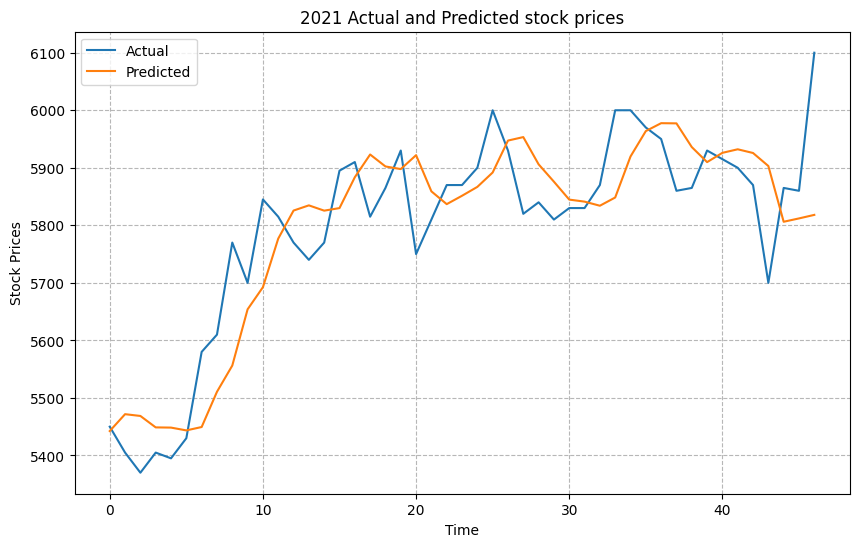

In [ ]:
evaluate_and_visualize(y_test_colombia_scale,predictions_colombia_scale)

In [ ]:
y_predicted6= np.squeeze(predictions_colombia_scale)
y_actual_colombia = np.squeeze(y_test_colombia_scale)
y_predicted6 = pd.Series(y_predicted6)

In [ ]:
rolling_mean6, upper_band6, lower_band6 = calculate_bollinger_bands(y_predicted6,window=14, num_std=1.5)

Buy at 5898.205078125
Sell at 6010.59765625
Buy at 5876.9697265625
Initial Capital: 10000
Final Capital: 10223.859340194096


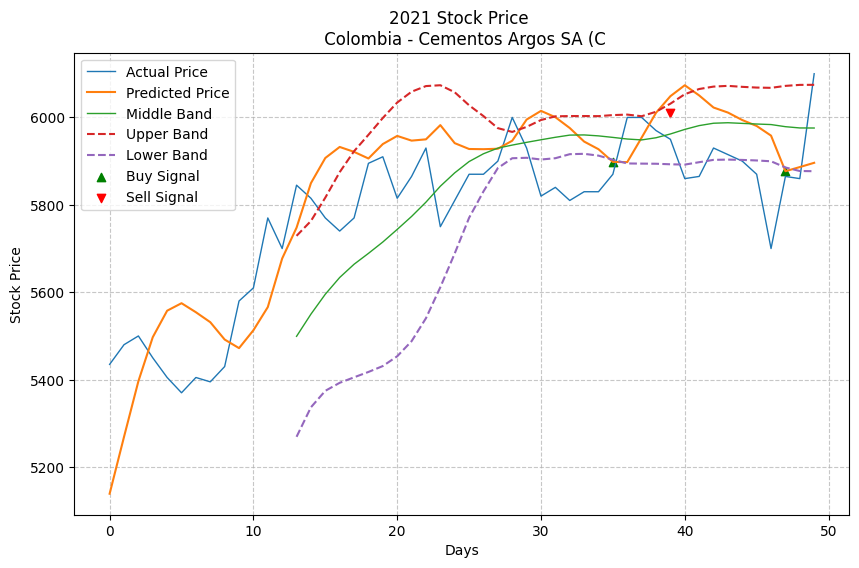

In [ ]:
stock_analysis(y_predicted6,rolling_mean6, upper_band6, lower_band6, trailing_stop=0.02, initial_capital=10000,y_actual=y_actual_colombia,company= 'Colombia - Cementos Argos SA (C')

Cementos Argos exhibited comparatively lower capital returns than other markets.

## **SOUTH AFRICA**
##  Impala Platinum Holdings Ltd.(IMPUY)

In [ ]:
southafrica_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,27373,26980,27526,26657,2.49M,0.0177
2021-03-30,26898,26766,27443,26360,3.02M,-0.0030
2021-03-29,26980,27800,28174,26614,4.44M,-0.0201
2021-03-26,27533,27083,28006,26728,3.36M,0.0365
2021-03-25,26564,25954,27128,25954,2.83M,0.0255


In [ ]:
southafrica_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2021-03-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     314 non-null    int64  
 1   Open      314 non-null    int64  
 2   High      314 non-null    int64  
 3   Low       314 non-null    int64  
 4   Vol.      314 non-null    object 
 5   Change %  314 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 17.2+ KB


In [ ]:
southafrica_test,southafrica_train = preprocess(southafrica_df)

<ipython-input-5-70c65ac5f485>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = data['2021']


In [ ]:
southafrica_train.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-31,20190,19990,20580,19702,9.214100e+11,0.0100
2020-12-30,19990,19743,20214,19722,1.120000e+06,0.0173
2020-12-29,19650,20300,20300,19636,1.220000e+06,0.0206
2020-12-28,20064,19600,20312,19290,5.973300e+11,0.0213
2020-12-24,19645,19260,19645,19135,3.515700e+11,0.0200


In [ ]:
southafrica_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-12-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     252 non-null    int64  
 1   Open      252 non-null    int64  
 2   High      252 non-null    int64  
 3   Low       252 non-null    int64  
 4   Vol.      252 non-null    float64
 5   Change %  252 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 13.8 KB


In [ ]:
southafrica_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2021-03-31 to 2021-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     62 non-null     int64  
 1   Open      62 non-null     int64  
 2   High      62 non-null     int64  
 3   Low       62 non-null     int64  
 4   Vol.      62 non-null     float64
 5   Change %  62 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 3.4 KB


In [ ]:
X_train7,y_train7 = prepare_and_reshape(southafrica_train,target_column='Price',scaler=scaler,time_steps=11)

In [ ]:
input_shape7 = (X_train7.shape[1], X_train7.shape[2])
model7 = build_lstm_model(input_shape7)

In [ ]:
model7.fit(X_train7, y_train7, epochs=50, batch_size=16)

Epoch 1/50
16/16 [==============================] - 1s 5ms/step - loss: 0.2864
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0073
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 10/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 11/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 12/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 13/50
16/16 [==============================

In [ ]:
y_test_southafrica_scale, predictions_southafrica_scale = preprocess_test_data(
    southafrica_test, scaler=scaler, target_column='Price', time_steps=11, model=model7)

2/2 [==============================] - 0s 6ms/step


Mean Absolute Error (MAE): 563.47
Root Mean Squared Error (RMSE): 713.54


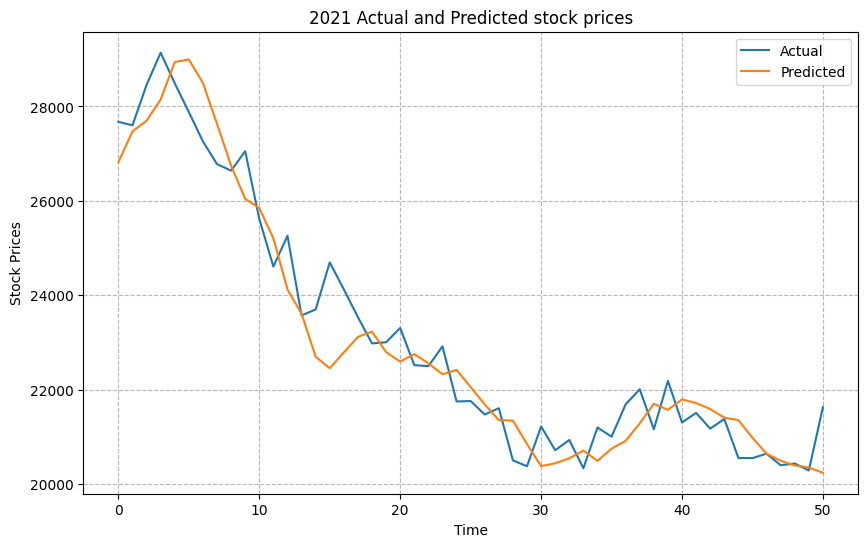

In [ ]:
evaluate_and_visualize(y_test_southafrica_scale,predictions_southafrica_scale)

In [ ]:
y_predicted7= np.squeeze(predictions_southafrica_scale)
y_actual_southafrica = np.squeeze(y_test_southafrica_scale)
y_predicted7 = pd.Series(y_predicted7)

In [ ]:
rolling_mean7, upper_band7, lower_band7 = calculate_bollinger_bands(y_predicted7,window=24, num_std=1.5)

Buy at 20381.474609375
Sell at 21355.265625
Initial Capital: 100000
Final Capital: 104777.82414809712


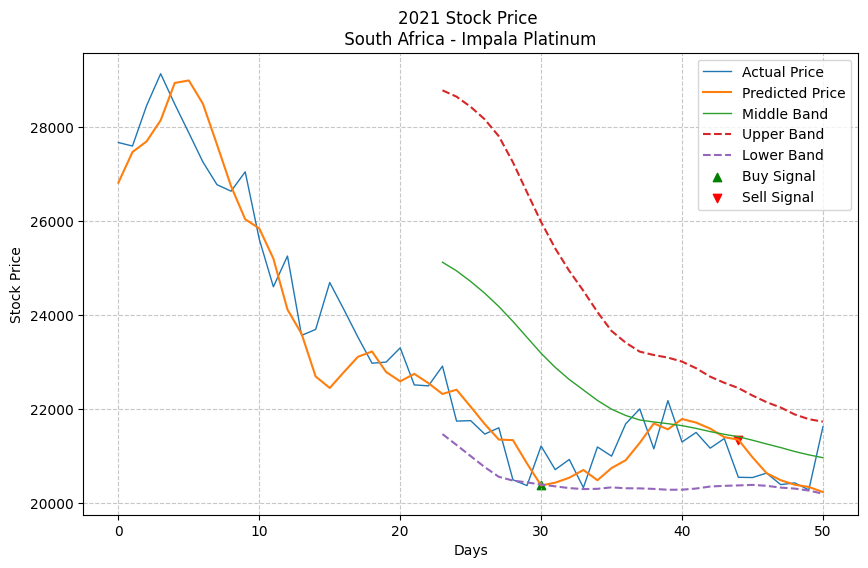

In [ ]:
stock_analysis(y_predicted7,rolling_mean7, upper_band7, lower_band7, trailing_stop=0.02, initial_capital=100000,y_actual=y_actual_southafrica,company= 'South Africa - Impala Platinum ')

Impala Platinum offers only one trading signal, but it yields a 5% return on capital with a maximum holding period.

## **SOUTH KOREA**
##  Dongkuk Steel Mill Co Ltd.

In [ ]:
south_korea_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,13650,13700,13750,13450,0.19K,0.0000
2021-03-30,13650,13850,14200,13050,3.17M,0.0074
2021-03-29,13550,12500,13800,12500,0.20K,0.1107
2021-03-28,12200,12200,12200,12200,-,0.0000
2021-03-26,12200,11500,12300,11350,2.34M,0.0796


In [ ]:
south_korea_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 2021-03-31 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     341 non-null    int64  
 1   Open      341 non-null    int64  
 2   High      341 non-null    int64  
 3   Low       341 non-null    int64  
 4   Vol.      341 non-null    object 
 5   Change %  341 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 18.6+ KB


In [ ]:
south_korea_test,south_korea_train = preprocess(south_korea_df)

<ipython-input-5-70c65ac5f485>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = data['2021']


In [ ]:
south_korea_train.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-30,8120,7860,8200,7770,1.550000e+06,0.0384
2020-12-29,7820,7700,7860,7650,6.431800e+11,0.0156
2020-12-28,7700,7780,7830,7630,0.000000e+00,0.0116
2020-12-27,7790,7790,7790,7790,0.000000e+00,0.0000
2020-12-24,7790,7850,7940,7720,6.700900e+11,0.0038


In [ ]:
south_korea_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 2021-03-31 to 2021-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     69 non-null     int64  
 1   Open      69 non-null     int64  
 2   High      69 non-null     int64  
 3   Low       69 non-null     int64  
 4   Vol.      69 non-null     float64
 5   Change %  69 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 3.8 KB


In [ ]:
south_korea_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 272 entries, 2020-12-30 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     272 non-null    int64  
 1   Open      272 non-null    int64  
 2   High      272 non-null    int64  
 3   Low       272 non-null    int64  
 4   Vol.      272 non-null    float64
 5   Change %  272 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 14.9 KB


In [ ]:
K.clear_session()

In [ ]:
X_train8,y_train8 = prepare_and_reshape(south_korea_train,target_column='Price',scaler=scaler,time_steps=5)

In [ ]:
input_shape8 = (X_train8.shape[1], X_train8.shape[2])
model8 = build_lstm_model(input_shape8)

In [ ]:
model8.fit(X_train8, y_train8, epochs=50, batch_size=16)

Epoch 1/50
17/17 [==============================] - 2s 5ms/step - loss: 0.2851
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.1431
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 0.0357
Epoch 4/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0099
Epoch 5/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0069
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 7/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 8/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 10/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 11/50
17/17 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 12/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 13/50
17/17 [==============================

In [ ]:
y_test_southkorea_scale, predictions_southkorea_scale = preprocess_test_data(
    south_korea_test, scaler=scaler, target_column='Price', time_steps=5, model=model8)

2/2 [==============================] - 0s 6ms/step


Mean Absolute Error (MAE): 308.70
Root Mean Squared Error (RMSE): 427.02


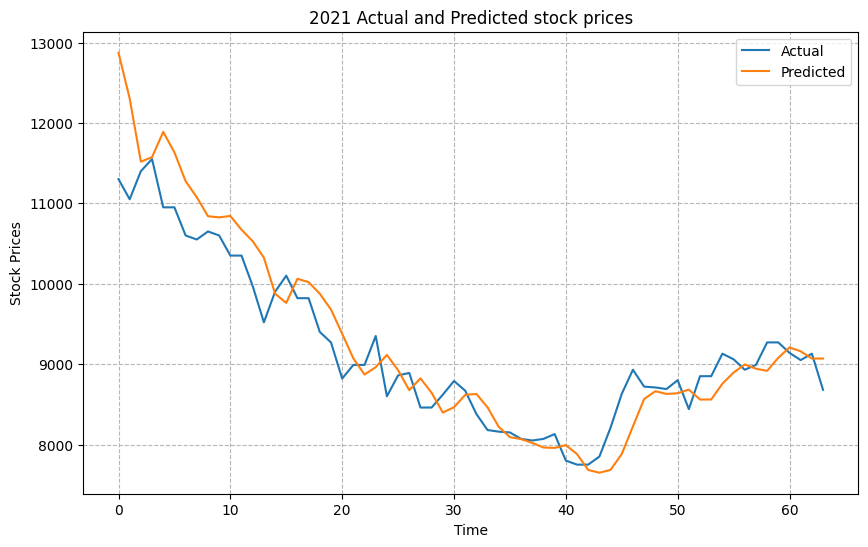

In [ ]:
evaluate_and_visualize(y_test_southkorea_scale,predictions_southkorea_scale)

In [ ]:
y_predicted8= np.squeeze(predictions_southkorea_scale)
y_actual_southkorea = np.squeeze(y_test_southkorea_scale)
y_predicted8 = pd.Series(y_predicted8)

In [ ]:
rolling_mean8, upper_band8, lower_band8 = calculate_bollinger_bands(y_predicted8,window=26, num_std=1.5)

Buy at 8676.2841796875
Sell at 8642.546875
Buy at 8397.572265625
Sell at 8462.2265625
Buy at 7683.5517578125
Sell at 8559.572265625
Initial Capital: 100000
Final Capital: 111822.42753048803


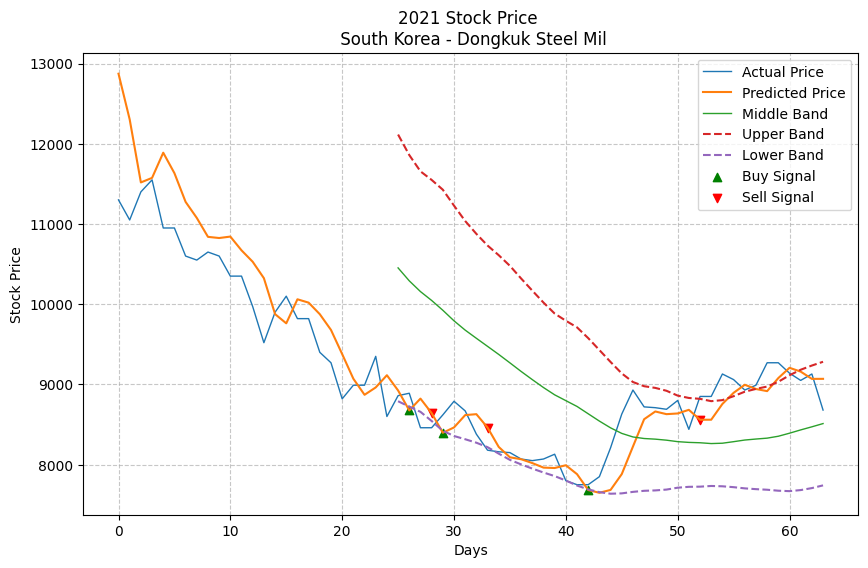

In [ ]:
stock_analysis(y_predicted8,rolling_mean8, upper_band8, lower_band8, trailing_stop=0.01, initial_capital=100000,y_actual=y_actual_southkorea,company= 'South Korea - Dongkuk Steel Mil')

By fine-tuning the window size, trailing stop, and standard deviation values, we obtained a 11% return on capital with maximum profit for predicted Dongkuk stocks, while also considering the recommended Buy and Sell signals.